<center><h1><b><span style="color:blue">"HEP Python ecosystem example"</span></b></h1></center>

#### **Goal of this exploration**

As said before, other groups and projects are working on other domain-specific areas towards the common goal of a modern, Pythonic and friendly analysis ecosystem for HEP. Let's play a bit with the `phasespace` and `zfit` packages from the [zfit project](https://github.com/zfit/).

We will generate some toy simulation data according to a model we want to look at, and will fit the data. This is a common task in HEP analysis. We will even make it a bit more complicated ... and will use `TensorFlow`.

Do not hesitate to play around, change things, use the ecosystem to produce plots differently, etc.!

&nbsp;<br><center><img src="images/logo_zfit.png" style="width:150px;"/></center>

<center><h2><b><span style="color:green">Model building and fitting library based on TensorFlow</span></b></h2></center>

The `zfit` package is a model fitting library based on TensorFlow and optimised for simple and direct manipulation of probability density functions. The main focus is on the scalability, parallelisation and a Pythonic user friendly experience framework.

## **A HEP common use-case - simultaneoous fit to a signal decay and a control mode**

<div class="alert alert-info">

<b>Acknowledgements:</b>

This tutorial is largely based on code kindly provided by Jonas Eschle (University of Zurich), the main author and maintainer of zfit.
It showcases the generation and fit of samples of $ B^0 \to \mu^+ \mu^- K^{*0}$ events (for the sake of example),
including a simultaneous fit, and the subsequent determination of the signal significance.
</div>

### Unbinned maximum likelihood model fit to $B^0 \to \mu^+ \mu^- K^{*0}$

The fit will be done in three steps using the `zfit` package:
- A fit with the (exponential) combinatorial background to the right-hand side of the signal peak, to obtain good starting values for the fitting parameters.
- A model composed of an exponential for the combinatorial background and a double Crystal Ball (DoubleCB) function for the $B^0 \to \mu^+ \mu^- K^{*0}$ signal is built and fitted to the "rare" mode. This is hard to get right, as we set low statistics in the rare mode.
- To improve the fit, the same model with a few shared parameters is built for the resonant mode $B^0 \to J/\psi (\to \mu^+ \mu^-) K^{*0}$,
  to improve the shape of the DoubleCB, as mostly the tails are tricky. They seem to be independent of $q^2 (\mu\mu)$, so we can share them.

### **0. Imports, settings, helper functions**

Let's start by importing
- Standard library modules
- Used Scikit-HEP packages
- `phasespace` and `zfit`

... this is what is meant by working with an ecosystem (where you take what you need, and no more) ;-).

In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

from particle.particle import literals as lp
from hepstats import hypotests

from phasespace import GenParticle

import os
os.environ['ZFIT_DISABLE_TF_WARNINGS'] = "True"  # suppresses TensorFlow warnings
import zfit
print('zfit version:', zfit.__version__)

zfit version: 0.5.4


**General settings**

In [2]:
seed = 11  # a "good" seed
tf.random.set_seed(seed)
np.random.seed(seed)

# Take the PDG particle masses from the Particle package.
B0_MASS = lp.B_0.mass
JPSI_MASS = lp.Jpsi_1S.mass
KSTARZ_MASS = lp.Kst_892_0.mass
KSTARZ_WIDTH = lp.Kst_892_0.width
PION_MASS = lp.pi_minus.mass
KAON_MASS = lp.K_plus.mass
MU_MASS = lp.mu_minus.mass

# Yields - feel free to change these to play around.
n_sig_rare = 120
n_sig_reso = 4000
n_bkg_rare = 5000
n_bkg_reso = 3000

# Detector smearing of the particles 4-momenta (sigma of a Gaussian).
rare_smearing = 7
reso_smearing = 7

**Helper functions**

In [3]:
def invariant_mass(four_momenta):
    """Calculate the invariant mass given four momenta with shape (n_events, 4) with px, py, pz, E."""
    momenta_squared = four_momenta ** 2
    return np.sqrt(momenta_squared[:, 3] - np.sum((momenta_squared[:, :3]), axis=-1))

Since the generation of the decays will be kinematically sampled from a fixed B mass, currently the reconstructed invariant B mass would only
be a sharp peak. To include detector resolution effects and make it look more like real data/MC, the particles are smeared according to the function below.

In [4]:
def smear_momenta(four_momenta, smearing=10):
    """Smears the momenta (gaussian) with a width of `smearing`."""
    # The four_momenta are "eager_tensors", wrapped numpy arrays. 
    # We could convert them with `np.array(four_momenta)`
    return np.random.normal(loc=four_momenta, scale=smearing)

### **1. Phasespace generation of the rare signal**

To generate the signal, we will sample from the phasespace of the decay and apply some ad-hoc smearing.
Using the `phasespace` package, a decay chain has to be sticked together with the different particles.
While this is simple to do for non-resonant particles with a fixed mass, since it is only a number,
phasespace allows also for (arbitrary) resonance shapes of the mass. Therefore, instead of a constant number,
a function that samples from the resonance can be provided, whereby `min_mass` and `max_mass` specify the kinematically
allowed boundaries for the mass. This is best illustrated with the example below.

The $K^{*0}$ is resonant; we define here the sampling of the mass.
Either zfit PDFs or TensorFlow Probability distributions (or anything using TensorFlow, also arbitrary
Python functions wrapped with `tf.py_function`, can be used). White TensorFlow Probability offers many useful
distributions, they often have support from -inf to inf, while zfit PDFs offer the possitility to sample only
within certain limits.

In [5]:
def kstar_mass(min_mass, max_mass, n_events):
    # Make sure everything is float64.
    min_mass = tf.cast(min_mass, tf.float64)
    max_mass = tf.cast(max_mass, tf.float64)
    kstar_width_cast = tf.cast(KSTARZ_WIDTH, tf.float64)
    kstar_mass_cast = tf.cast(KSTARZ_MASS, dtype=tf.float64)

    # To produce n_events samples, we can e.g. broadcast the K*0 mass (currently a scalar)
    # to have the right shape (n_events,). But there are many ways, also see TensorFlow Probability Distributions.
    kstar_mass = tf.broadcast_to(kstar_mass_cast, shape=(n_events,))
    if KSTARZ_WIDTH > 0:
        kstar_mass = tfp.distributions.TruncatedNormal(loc=kstar_mass,
                                                       scale=kstar_width_cast,
                                                       low=min_mass,
                                                       high=max_mass).sample()
    return kstar_mass

**1.a. Decay chain generation with smeared momenta for the daughter particles**

In [6]:
# Create the K*0 and also set its children.
kstar = GenParticle('K*0', mass=kstar_mass).set_children(GenParticle('K+', mass=KAON_MASS),
                                                         GenParticle('pi-', mass=PION_MASS))
bz = GenParticle('B0', B0_MASS).set_children(kstar,
                                             GenParticle('mu+', mass=MU_MASS),
                                             GenParticle('mu-', mass=MU_MASS))

# `generate` returns the weights of the event and a dict which contains the 4-momenta of the particles
# as {particle_name: EagerTensor of shape (n_events, 4)}, where an EagerTensor is basically a wrapped NumPy array.
# and the particle_name is e.g. 'K+', 'K*0', the name that has been used above.
weights, particles = bz.generate(n_sig_rare)
weights = weights / np.average(weights)
weights = weights.numpy()

# Since this is kinematically sampled from a fixed B0 mass, currently the reconstructed invariant B0 mass would only
# be a sharp peak. To include detector resolution effects and make it look more like real data/MC, the particles are smeared.
smeared_momenta = {}
daugther_particles = ['K+', 'pi-', 'mu+', 'mu-']
for particle in daugther_particles:
    smeared_momenta[particle] = smear_momenta(particles[particle], smearing=rare_smearing)

# Reconstruct the mother particles using the smeared daughters.
smeared_momenta['K*0'] = smeared_momenta['K+'] + smeared_momenta['pi-']
# Reminder - no J/psi in the rare mode. The name 'Jpsi' is simply used for convenience.
smeared_momenta['Jpsi'] = smeared_momenta['mu+'] + smeared_momenta['mu-']
smeared_momenta['B0'] = smeared_momenta['K*0'] + smeared_momenta['Jpsi']

The B0 invariant mass and (mu+,mu-)-pair invariant mass squared are simply

In [7]:
b_mass_rare = invariant_mass(smeared_momenta['B0'])
q2 = invariant_mass(smeared_momenta['Jpsi']) ** 2

# Indeed n_sig_rare decays have been generated
b_mass_rare.size == q2.size == n_sig_rare

True

**1.b. Visualisation of the spectrum**

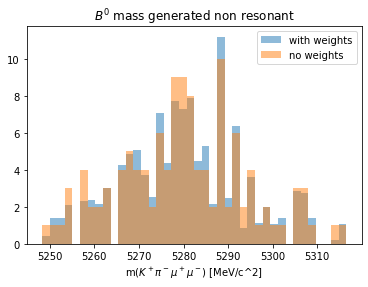

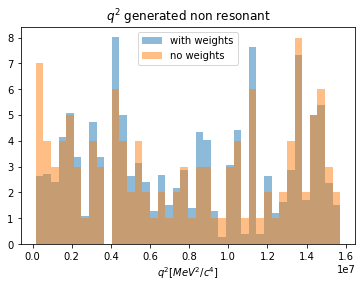

In [8]:
# X-axis label, to be used later.
xlabel_bmass = 'm($K^+ \pi^- \mu^+ \mu^-$) [MeV/c^2]'

# Plot the B0 mass with the weights. It is basically the same as without weights.
plt.figure()
plt.title("$B^0$ mass generated non resonant")
plt.hist(b_mass_rare, weights=weights, alpha=0.5, bins=40, label="with weights")
plt.hist(b_mass_rare, bins=40, alpha=0.5, label="no weights")
plt.xlabel(xlabel_bmass)
plt.legend()

plt.figure()
plt.title("$q^2$ generated non resonant")
plt.hist(q2, weights=weights, alpha=0.5, bins=40, label="with weights")
plt.hist(q2, bins=40, alpha=0.5, label="no weights")
plt.xlabel('$q^2 [MeV^2/c^4]$')
plt.legend()

### **2. Fit to the rare signal**

As a reminder (see above), the fit of the rare (non-resonant) decay will be done in three steps:
- A fit with the (exponential) combinatorial background to the right-hand side of the signal peak, to obtain good starting values for the fitting parameters.
- A model composed of an exponential for the combinatorial background and a DoubleCB function for the $B^0 \to \mu^+ \mu^- K^{*0}$ signal is built and fitted to the "rare" mode. This is hard to get right, as we set low statistics in the rare mode.
- In the next section the resonant mode $B^0 \to J/\psi (\to \mu^+ \mu^-) K^{*0}$ will be exploited to improve the fit,
  using the same model with a few shared parameters.

#### If the fit does not converge

Finding the minimum given some parameters is in general not a simple problem. Two major reasons this does
not work well are the initial values and the *step size*, which may be too far off or too large/small. The latter
should be around the uncertainty of the parameter (once the fit will be converged). More information can be
found at https://github.com/zfit/zfit/wiki/FAQ#fitting-and-minimization.

**2.a Fit to the right-hand sideband**

The range of the mass, the observable, defines the range of the data and hence of the fit - [5000, 5600] MeV.

In [9]:
# The observable and its range are defined.
upper_limit = 5600
obs = zfit.Space('Bmass', (5000, upper_limit))  # for whole range
obs_bkg = zfit.Space('Bmass', (5400, upper_limit))  # to pre-fit the exponential

We first need to generate some background data! Indeed only signal has been generated so far.

In [10]:
# Parameters are specified:  (name (unique), initial, lower, upper) whereas lower, upper are optional.
lambda_rare = zfit.Parameter('lambda_rare', -0.002, -0.01, -0.0001, step_size=0.0005)  # floating, also without limits
comb_bkg_rare = zfit.pdf.Exponential(lambda_rare, obs=obs)

# Create the background data.
comb_bkg_rare_sample = comb_bkg_rare.sample(n=n_bkg_rare)  # sampled within the limits of `obs`

At last, the right-hand side of the data, which is only the combinatorial background freshly generated, is fitted to the exponential model in order to get a good initial value.

In [11]:
right_tale_data_rare = zfit.Data.from_numpy(obs=obs_bkg, array=comb_bkg_rare_sample.value())

# Set the value of lambda to something different than we sampled from (for the fit afterwards).
lambda_rare.set_value(-0.003)

# The normalisation range is temporarily set to the right-hand side only.
with comb_bkg_rare.set_norm_range(obs_bkg):
    right_tale_loss = zfit.loss.UnbinnedNLL(comb_bkg_rare, right_tale_data_rare)
    minimizer = zfit.minimize.Minuit(verbosity=7, use_minuit_grad=True)
    result_right_tale = minimizer.minimize(right_tale_loss)

/srv/conda/envs/notebook/lib/python3.8/site-packages/zfit/minimizers/minimizer_minuit.py:165: IMinuitWarning: Setting print_level >=3 has the side-effect of setting the level globally for all Minuit instances
  minimizer = iminuit.Minuit.from_array_func(fcn=func, start=start_values,
/srv/conda/envs/notebook/lib/python3.8/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5530                       │        Ncalls = 22 (22 total)        │
│ EDM = 1.15e-05 (Goal: 0.001)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘


In [12]:
result_right_tale

FitResult of
<UnbinnedNLL model=[<zfit.Exponential  params=[lambda_rare] dtype=float64>0] data=[<zfit.core.data.Data object at 0x7f5f78295f10>] constraints=[]> 
with
<Minuit strategy=PushbackStrategy tolerance=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.2e-05 │ 5530        │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value    at limit
-----------  ----------  ----------
lambda_rare  -0.0008876       False

**2.b Fit to the full spectrum**

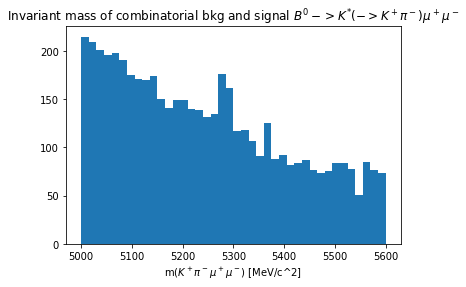

In [13]:
# Create the data for the rare fit
rare_data_np = np.concatenate([b_mass_rare, comb_bkg_rare_sample[:, 0]], axis=0)
rare_weights_np = np.concatenate([weights, np.ones_like(comb_bkg_rare_sample[:, 0])], axis=0)
# TODO: we could do some data preprocessing here (e.g. apply a cut to q2, which we actually
# need to have "no Jpsi" in there). This can be done with pandas and then loaded into zfit

rare_data = zfit.Data.from_numpy(obs=obs, array=rare_data_np, weights=rare_weights_np)
# Data can also be loaded from ROOT
# right_tale_data_rare = zfit.Data.from_root(...)

# ...or to/from a pandas DataFrame. Either convert the `zfit.Data` to a pandas DF
# right_tale_data_rare_df = right_tale_data_rare.to_pandas()
# .... or create it from scratch
# right_tale_data_rare_df = pd.DataFrame(data=rare_data_np, columns=obs_bkg.obs)
# Then we can directly load it
# right_tale_data_rare = zfit.Data.from_pandas(df=right_tale_data_rare_df, obs=obs_bkg)

# (maybe remove plot, just for data visualisation example?)
plt.figure()
plt.title("Invariant mass of combinatorial bkg and signal $B^0 -> K^{*} (-> K^+ \pi^-) \mu^+ \mu^-$")
plt.hist(rare_data_np, weights=rare_weights_np, bins=40)
plt.xlabel(xlabel_bmass)

# Create the model to fit to the rare mode

# Parameters for the model
mu = zfit.Parameter('mu', 5270, 5200, 5350, step_size=3)
sigma = zfit.Parameter('sigma', 22, 1, 100, step_size=0.1)

# A double crystalball, a sum of two Crystal Ball functions will be used
alphal_rare = zfit.Parameter('alpha left rare', -0.3, -5, 0)
nl_rare = zfit.Parameter('n left rare', 0.3, 0, 10)
alphar_rare = zfit.Parameter('alpha right rare', 1, 0, 5)
nr_rare = zfit.Parameter('n right rare', 2.8, 0, 10)
frac_dcb_rare = zfit.Parameter('frac dcb', 0.3, 0.1, 0.9)

left_cb_rare = zfit.pdf.CrystalBall(obs=obs,
                                    mu=mu, sigma=sigma,
                                    alpha=alphal_rare, n=nl_rare,
                                    )
right_cb_rare = zfit.pdf.CrystalBall(obs=obs,
                                     mu=mu, sigma=sigma,
                                     alpha=alphar_rare, n=nr_rare,
                                     )
signal_rare = zfit.pdf.SumPDF([left_cb_rare, right_cb_rare], fracs=frac_dcb_rare)


# Create the yields and the extended pdfs
rare_sig_yield = zfit.Parameter('rare_sig_yield', n_sig_rare + 30,
                                step_size=3)  # step size: default is small, use appropriate
rare_bkg_yield = zfit.Parameter('rare_bkg_yield', n_bkg_rare - 40, step_size=1)
# Create extended PDFs
extended_sig_rare = signal_rare.create_extended(rare_sig_yield)
extended_bkg_rare = comb_bkg_rare.create_extended(rare_bkg_yield)

# The final model is the combination of the signal and backgrond pdf
model_rare = zfit.pdf.SumPDF([extended_sig_rare, extended_bkg_rare])


# Different models could be used here. A more simple model, such as a Gaussian...
# signal_rare = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)

# ...or even a completely custom PDF. Explained also here: 
# https://zfit.readthedocs.io/en/latest/getting_started/intro/model.html#custom-pdf
# from zfit import z  # backend, can also use TensorFlow directly
#
# class MySignal(zfit.ZPDF):
#     _N_OBS = 1
#     _PARAMS = ['mean', 'width']
#    
#     # Implement the shape (unnormalized) of your pdf. If the analytical integral is known, it can be
#     # registered later on.
#     def _unnormalized_pdf(self, x):
#         x = z.unstack(x)  # could be higher dimensional
#         mean = self.params['mean']
#         width = self.params['width']
#         return z.exp((x - mean) ** 2 / (2 * width ** 2))  # Gaussian, unnormalized
#
#
# signal_rare = MySignal(mean=mu, width=sigma, obs=obs)

**2.c. Visualisation of the spectrum**

<ipython-input-14-632c93bbcb5d>:5: UserWarning: The function <function Space.area at 0x7f5fa5a8ad30> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('Bmass',), axes=(0,), limits=(array([[5000.]]), array([[5600.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  plot_scaling = data.nevents / n_bins * space.area()
<ipython-input-14-632c93bbcb5d>:6: UserWarning: The function <function Space.limit1d at 0x7f5fa5a8af70> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('Bmass',), axes=(0,), limits=(array([[5000.]]), array([[5600.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  lower, upper = space.limit1d


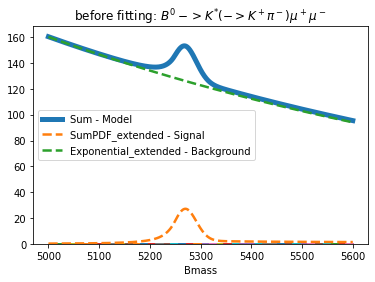

/srv/conda/envs/notebook/lib/python3.8/site-packages/zfit/minimizers/minimizer_minuit.py:165: IMinuitWarning: Setting print_level >=3 has the side-effect of setting the level globally for all Minuit instances
  minimizer = iminuit.Minuit.from_array_func(fcn=func, start=start_values,
/srv/conda/envs/notebook/lib/python3.8/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -6177                      │       Ncalls = 728 (728 total)       │
│ EDM = 0.000341 (Goal: 0.001)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘


/srv/conda/envs/notebook/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


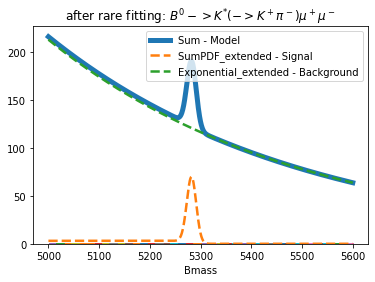

In [14]:
# In order to plot our model, a helper function is created
def plot_pdf_data(data, model, title, n_bins=40):
    linewidth = 2.5
    space = data.data_range
    plot_scaling = data.nevents / n_bins * space.area()
    lower, upper = space.limit1d
    x = np.linspace(lower, upper, 1000)

    plt.figure()
    plt.title(title)

    # plot the data
    data_np = data[:, 0]
    plt.hist(data_np,
             # color=color,
             bins=n_bins, histtype="stepfilled", alpha=0.1)
    plt.hist(data_np,
             # color=color,
             bins=n_bins, histtype="step")
    # plot the pdfs
    y = zfit.run(model.pdf(x))
    y_sig = zfit.run(model.pdfs[0].pdf(x) * model.fracs[0])# notice the frac!
    y_bkg = zfit.run(model.pdfs[1].pdf(x) * model.fracs[1])  # notice the frac!

    plt.plot(x, y * plot_scaling, label="Sum - Model", linewidth=linewidth * 2)
    plt.plot(x, y_sig * plot_scaling, '--', label=f"{model.pdfs[0].name} - Signal", linewidth=linewidth)
    plt.plot(x, y_bkg * plot_scaling, '--', label=f"{model.pdfs[1].name} - Background", linewidth=linewidth)
    plt.xlabel(space.obs[0])
    plt.legend()
    

plot_pdf_data(data=rare_data, model=model_rare, title='before fitting: $B^0 -> K^{*} (-> K^+ \pi^-) \mu^+ \mu^-$')
plt.show()

# As a next step, the loss is created: the minimum of it defines the solution to the problem
ext_rare_nll = zfit.loss.ExtendedUnbinnedNLL(model_rare, rare_data)

# The minimization uses by default all floating parameters (that the model(s) used in the loss depend on)
# but they can also be explicitly specified as an argument to `minimize`.
result_rare = minimizer.minimize(ext_rare_nll)

# The parameter values are set automatically to the value found at the minimum.
plot_pdf_data(data=rare_data, model=model_rare, title='after rare fitting: $B^0 -> K^{*} (-> K^+ \pi^-) \mu^+ \mu^-$')
plt.show()

In [15]:
# The information about the minimization and the result of it are stored in the
# FitResult that is returned. It contains e.g. information about the parameters
pprint(result_rare.params)

# ...and more:
print(f"The fit converged: {result_rare.converged}, the minimum is {result_rare.fmin}")

# Following are error estimations. They return the result and also add it into the `params` attribute.
# Unfortunately, hesse is currently not yet supported with weights.
# result_rare.hesse()  # error calculation using the inverse hessian approximation
# result_rare.error()  # error calculation using minos, this takes all parameters (expensive)
result_rare.error([rare_sig_yield, mu])  # just for specific parameters
pprint(result_rare.params)

# the params can be accesssed using the parameter objects (not their names!)
mu_rare_fit = result_rare.params[mu]
# they contain information about the result such as value etc
print(f"Mu value of rare fit: {mu_rare_fit['value']} "
      f"+ {mu_rare_fit['minuit_minos']['upper']} "
      f"- {mu_rare_fit['minuit_minos']['upper']}"
      # f" (symmetric Hesse error: {mu_rare_fit['minuit_hesse']['error']})"
      )

{<zfit.Parameter 'alpha left rare' floating=True value=-4.257>: {'value': -4.257120196987471},
 <zfit.Parameter 'lambda_rare' floating=True value=-0.002011>: {'value': -0.002011039131642748},
 <zfit.Parameter 'n right rare' floating=True value=6.539e-05>: {'value': 6.538538570688424e-05},
 <zfit.Parameter 'alpha right rare' floating=True value=0.0002425>: {'value': 0.00024249741221837873},
 <zfit.Parameter 'n left rare' floating=True value=0.486>: {'value': 0.4860143679129342},
 <zfit.Parameter 'frac dcb' floating=True value=0.6304>: {'value': 0.6303764661916278},
 <zfit.Parameter 'sigma' floating=True value=9.264>: {'value': 9.263629853806707},
 <zfit.Parameter 'rare_sig_yield' floating=True value=164.3>: {'value': 164.3393120596956},
 <zfit.Parameter 'rare_bkg_yield' floating=True value=4956>: {'value': 4956.343502826942},
 <zfit.Parameter 'mu' floating=True value=5282>: {'value': 5282.028559912763}}
The fit converged: True, the minimum is -6177.436256880177


/srv/conda/envs/notebook/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:360: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


{<zfit.Parameter 'alpha left rare' floating=True value=-1.944>: {'value': -4.257120196987471},
 <zfit.Parameter 'lambda_rare' floating=True value=-0.002036>: {'value': -0.002011039131642748},
 <zfit.Parameter 'alpha right rare' floating=True value=6.129e-07>: {'value': 0.00024249741221837873},
 <zfit.Parameter 'n right rare' floating=True value=0.06404>: {'value': 6.538538570688424e-05},
 <zfit.Parameter 'frac dcb' floating=True value=0.8248>: {'value': 0.6303764661916278},
 <zfit.Parameter 'n left rare' floating=True value=5.224>: {'value': 0.4860143679129342},
 <zfit.Parameter 'sigma' floating=True value=9.416>: {'value': 9.263629853806707},
 <zfit.Parameter 'rare_sig_yield' floating=True value=164.3>: {'minuit_minos': MError(name='rare_sig_yield', is_valid=False, lower=-1.4121631534391828, upper=1.4121631534391828, lower_valid=False, upper_valid=False, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=True, upper_new_min=True, 

### **3. Phasespace generation of the resonant decay**

Since the previous fit, e.g. the tail, was not great due to the lack of statistics, we can also fit the resonant mode simultaneously and share certain parameters.

**3.a. Signal decay chain generation with smeared momenta for the daughter particles**

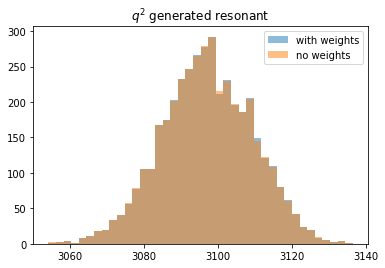

In [16]:
# Create the resonant decay. This is basically the same as above, we simply add an intermediate Jpsi.
bz = GenParticle('B0', B0_MASS).set_children(kstar,
                                             GenParticle('Jpsi', mass=JPSI_MASS).set_children(
                                                 GenParticle('mu+', mass=MU_MASS),
                                                 GenParticle('mu-', mass=MU_MASS)
                                             ))

weights_reso, particles_reso = bz.generate(n_sig_reso)
weights_reso /= np.average(weights_reso)
weights_reso = weights_reso.numpy()

smeared_momenta_reso = {}
daugther_particles_reso = ['K+', 'pi-', 'mu+', 'mu-']
for particle in daugther_particles_reso:
    smeared_momenta_reso[particle] = smear_momenta(particles_reso[particle], smearing=reso_smearing)

smeared_momenta_reso['K*0'] = smeared_momenta_reso['K+'] + smeared_momenta_reso['pi-']
smeared_momenta_reso['Jpsi'] = smeared_momenta_reso['mu+'] + smeared_momenta_reso['mu-']
smeared_momenta_reso['B0'] = smeared_momenta_reso['K*0'] + smeared_momenta_reso['Jpsi']

b_mass_reso = invariant_mass(smeared_momenta_reso['B0'])
q2_reso = invariant_mass(smeared_momenta_reso['Jpsi'])

# plot the q2
plt.figure()
plt.title("$q^2$ generated resonant")
plt.hist(q2_reso, weights=weights_reso, alpha=0.5, bins=40, label="with weights")
plt.hist(q2_reso, bins=40, alpha=0.5, label="no weights")
plt.legend()

**3.b. Combinatorial background generation**

In [17]:
lambda_reso = zfit.Parameter('lambda_reso', -0.002, -0.01, 0.0001)  # floating, also without limits
comb_bkg_reso_pdf = zfit.pdf.Exponential(lambda_reso, obs=obs)

# Create some background data
comb_bkg_reso_sample = comb_bkg_reso_pdf.sample(n=n_bkg_reso)  # sampled within the limits of `obs`

# Set the value of lambda to smth different then we sampled from (for the fit afterwards)
lambda_reso.set_value(-0.01)

**3.c. Signal + background data set**

In [18]:
reso_data_np = np.concatenate([b_mass_reso, comb_bkg_reso_sample[:, 0]], axis=0)
reso_weights_np = np.concatenate([weights_reso, np.ones_like(comb_bkg_reso_sample[:, 0])], axis=0)

reso_data = zfit.Data.from_numpy(obs=obs, array=reso_data_np)

**3.d. Visualisation of the full spectrum**

(array([ 125.        ,  129.        ,  129.        ,  117.        ,
         124.        ,  117.        ,  108.        ,   96.        ,
          89.        ,  109.        ,   85.        ,   87.        ,
          87.        ,   89.        ,   85.        ,   88.19688328,
         218.88169002,  896.229071  , 1689.92696254, 1202.24231287,
         332.34392984,   84.17915045,   67.        ,   53.        ,
          77.        ,   49.        ,   63.        ,   43.        ,
          56.        ,   52.        ,   41.        ,   49.        ,
          50.        ,   53.        ,   44.        ,   46.        ,
          24.        ,   55.        ,   49.        ,   41.        ]),
 array([5000.22704681, 5015.22133792, 5030.21562903, 5045.20992015,
        5060.20421126, 5075.19850238, 5090.19279349, 5105.1870846 ,
        5120.18137572, 5135.17566683, 5150.16995795, 5165.16424906,
        5180.15854017, 5195.15283129, 5210.1471224 , 5225.14141352,
        5240.13570463, 5255.12999574, 5270.124

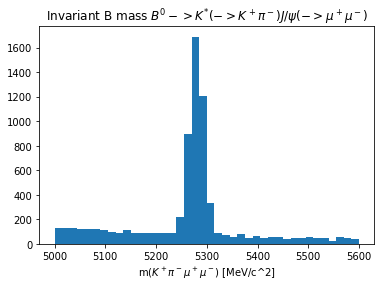

In [19]:
# (maybe remove plot, just for data visualization example?)
plt.figure()
plt.title("Invariant B mass $B^0 -> K^{*} (-> K^+ \pi^-) J/\psi (-> \mu^+ \mu^-)$")
plt.xlabel(xlabel_bmass)
plt.hist(reso_data_np, weights=reso_weights_np, bins=40)

**3.e Model for the resonant decay**

Create the full model to fit the spectrum of the resonant signal model and its related combinatorial background.

In [20]:
# we can share parameters directly or create composed parameters. Here we have a
# parameter that scales the sigma from the rare fit

sigma_scaling = zfit.Parameter('sigma_scaling', 0.9, 0.5, 10, step_size=0.1)


def sigma_scaled_fn():
    return sigma * sigma_scaling  # this can be an arbitrary function


sigma_scaled = zfit.ComposedParameter('sigma scaled', sigma_scaled_fn,
                                      dependents=sigma  # the objects used inside the function
                                      )

# Instead of sharing, free parameters could be used. This would though defy the purpose of the simultaneous fit here.
# If we know that some can't be shared though (e.g. the tails between a muon and electron modes), only certain parameters can be shared.
# alphal_reso = zfit.Parameter('alpha left reso', -0.7, -5, 0)
# nl_reso = zfit.Parameter('n left reso', 0.4, 0, 10)
# alphar_reso = zfit.Parameter('alpha right reso', 1, 0, 5)
# nr_reso = zfit.Parameter('n right reso', 1.8, 0, 10)
alphal_reso = alphal_rare
nl_reso = nl_rare
alphar_reso = alphal_rare
nr_reso = nr_rare

# frac_dcb_reso = zfit.Parameter('frac dcb_reso', 0.5, 0.01, 0.99)
frac_dcb_reso = frac_dcb_rare
left_cb_reso = zfit.pdf.CrystalBall(obs=obs,
                                    mu=mu, sigma=sigma_scaled,
                                    alpha=alphal_reso, n=nl_reso,
                                    )
right_cb_reso = zfit.pdf.CrystalBall(obs=obs,
                                     mu=mu, sigma=sigma_scaled,
                                     alpha=alphar_reso, n=nr_reso,
                                     )
signal_reso = zfit.pdf.SumPDF([left_cb_reso, right_cb_reso], fracs=frac_dcb_reso)

# Again, also a simpler (or custom) shape could be used
# signal_reso = zfit.pdf.Gauss(mu=mu,  # using the same mu as above means it's shared
#                              sigma=sigma_scaled, obs=obs)

reso_sig_yield = zfit.Parameter('reso_sig_yield', n_sig_reso - 100, 0, n_sig_reso * 3,
                                step_size=1)  # step size: default is small, use appropriate
reso_bkg_yield = zfit.Parameter('reso_bkg_yield', n_bkg_reso + 70, 0, n_bkg_reso * 3, step_size=1)

# Create the extended models
extended_sig_reso = signal_reso.create_extended(reso_sig_yield)
extended_bkg_reso = comb_bkg_reso_pdf.create_extended(reso_bkg_yield)
model_reso = zfit.pdf.SumPDF([extended_bkg_reso, extended_sig_reso])

/srv/conda/envs/notebook/lib/python3.8/site-packages/zfit/core/parameter.py:761: UserWarning: `dependents` is deprecated, use `params` instead.
  warnings.warn("`dependents` is deprecated, use `params` instead.")


### **4. Simultaneous fit**

- Built the simultaneous loss function.
- Run the simultaneous fit.
- Print and plot the fit results.

In [21]:
# Constraints could also be added to the loss, we don't have a good use-case here, so we leave them away.
# They usually resemble other measurements of a parameter with an uncertainty in the same order of
# magnitude as the sensitivity of our fit. Too strong constraint parameters can be though of as constants,
# too loose do not add anything.
# constraint = zfit.constraint.GaussianConstraint(mu, observation=5279, uncertainty=50)
# ext_reso_nll = zfit.loss.ExtendedUnbinnedNLL(model_reso, reso_data, constraints=constraint)

ext_reso_nll = zfit.loss.ExtendedUnbinnedNLL(model_reso, reso_data)

# to create a simultaneous loss, the individual losses are added
simultaneous_loss = ext_reso_nll + ext_rare_nll

result_simult = minimizer.minimize(simultaneous_loss)

/srv/conda/envs/notebook/lib/python3.8/site-packages/zfit/core/loss.py:99: UserWarning: The fit_range argument is depreceated and will maybe removed in future releases. It is preferred to define the range in the space when creating the data and the model.
  warnings.warn("The fit_range argument is depreceated and will maybe removed in future releases. "
/srv/conda/envs/notebook/lib/python3.8/site-packages/zfit/minimizers/minimizer_minuit.py:165: IMinuitWarning: Setting print_level >=3 has the side-effect of setting the level globally for all Minuit instances
  minimizer = iminuit.Minuit.from_array_func(fcn=func, start=start_values,
/srv/conda/envs/notebook/lib/python3.8/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.eq

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -2.235e+04                 │       Ncalls = 338 (338 total)       │
│ EDM = 0.000562 (Goal: 0.001)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘


In [22]:
result_simult

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.SumPDF  params=[Composed_autoparam_8, Composed_autoparam_9] dtype=float64>0, <zfit.SumPDF  params=[Composed_autoparam_3, Composed_autoparam_4] dtype=float64>0] data=[<zfit.core.data.Data object at 0x7f5f782654c0>, <zfit.core.data.Data object at 0x7f5f786b3f10>] constraints=[]> 
with
<Minuit strategy=PushbackStrategy tolerance=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00056 │ -2.235e+04  │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name                  value    at limit
----------------  ---------  ----------
reso_bkg_yield         3002       False
reso_sig_yield         3998       False
lambda_reso       -0.002074       False
frac dcb             0.8773       False
alpha left rare     

/srv/conda/envs/notebook/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


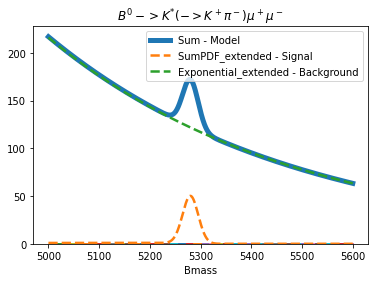

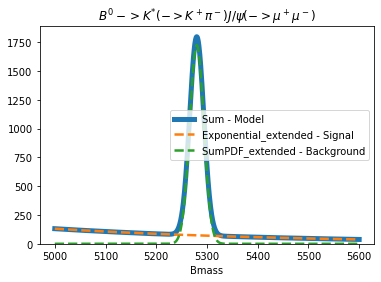

/srv/conda/envs/notebook/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:360: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


OrderedDict([(<zfit.Parameter 'mu' floating=True value=5280>,
              MError(name='mu', is_valid=False, lower=-0.24507226105066146, upper=0.2024576691751463, lower_valid=True, upper_valid=False, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=621, min=5279.871817830991)),
             (<zfit.Parameter 'rare_sig_yield' floating=True value=144.7>,
              MError(name='rare_sig_yield', is_valid=False, lower=-41.13230607916881, upper=25.254643167727455, lower_valid=True, upper_valid=False, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=True, nfcn=765, min=144.68263211015116)),
             (<zfit.Parameter 'reso_sig_yield' floating=True value=3998>,
              MError(name='reso_sig_yield', is_valid=False, lower=-66.82402624165684, upper=66.82402624165684, lower_valid=False, upper_valid=False, at_lower_limit

In [23]:
plot_pdf_data(data=rare_data, model=model_rare, title='$B^0 -> K^{*} (-> K^+ \pi^-) \mu^+ \mu^-$')
plot_pdf_data(data=reso_data, model=model_reso, title='$B^0 -> K^{*} (-> K^+ \pi^-) J/\psi (-> \mu^+ \mu^-)$')
plt.show()

# Hesse is not yet supported with weights
# result_simult.hesse()  # error calculation using hesse
errors = result_simult.error([mu, rare_sig_yield, reso_sig_yield])  # error calculation using minos, just for a few
# parameters as it is quite expensive
pprint(errors)

### **5. Wrapping up - determination of the signal significance**

Going beyond the fits one is often interested in obtaining limits or calculate signal significances.
These statistical procedures usually perform multiple fits with certain parameters fixed.

For this purpose, the `bhepstats` library can be used. It is built on top of the same interface that `zfit`
uses and therefore integrates well together. Models built and fits done in `zfit` will directly work with `hepstats`.

In [24]:
from hepstats.hypotests import Discovery
from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests.parameters import POI

calculator = AsymptoticCalculator(simultaneous_loss, minimizer)
poinull = POI(rare_sig_yield, 0)
discovery_test = Discovery(calculator, poinull)
pnull, significance = discovery_test.result()
print(f'pnull: {pnull} with significance {significance}')

Get fit best values!


/srv/conda/envs/notebook/lib/python3.8/site-packages/zfit/minimizers/minimizer_minuit.py:165: IMinuitWarning: Setting print_level >=3 has the side-effect of setting the level globally for all Minuit instances
  minimizer = iminuit.Minuit.from_array_func(fcn=func, start=start_values,


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -2.235e+04                 │      Ncalls = 1166 (1166 total)      │
│ EDM = 3.21e-05 (Goal: 0.001)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

p_value for the Null hypothesis = 1.5103277184458364e-08
Significance (in units of sigma) = 5.540235274810547
pnull: 1.5103277184458364e-08 with significance 5.540235274810547
